In [2]:
import torch
import torch.optim as optim
import torch.nn as nn

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # unsqueeze add extra dimension to accomodate for B*Nin batches * number of inputs
t_u = torch.tensor(t_u).unsqueeze(1)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples) # random

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

print(train_indices, val_indices)

# split data in train and validation sets
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

tensor([6, 2, 7, 5, 3, 8, 4, 0, 1]) tensor([ 9, 10])


In [3]:
linear_model = nn.Linear(1, 1)
print(linear_model(val_t_un))
print(linear_model.weight)
print(linear_model.bias)
print(list(linear_model.parameters()))

tensor([[-4.8915],
        [-5.5568]], grad_fn=<AddmmBackward0>)
Parameter containing:
tensor([[-0.8317]], requires_grad=True)
Parameter containing:
tensor([0.1319], requires_grad=True)
[Parameter containing:
tensor([[-0.8317]], requires_grad=True), Parameter containing:
tensor([0.1319], requires_grad=True)]


In [4]:
# nn modules expect that input tensor have as first dimension the number of items in the batch, so it will compute multiple items in one operation
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.6998],
        [-0.6998],
        [-0.6998],
        [-0.6998],
        [-0.6998],
        [-0.6998],
        [-0.6998],
        [-0.6998],
        [-0.6998],
        [-0.6998]], grad_fn=<AddmmBackward0>)

In [5]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training loss {loss_train:.4f}, Validation loss {loss_val:.4f}')

In [6]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(n_epochs=3000,
              optimizer=optimizer,
              model=linear_model,
              loss_fn=nn.MSELoss(),
              t_u_train=train_t_un,
              t_u_val=val_t_un,
              t_c_train=train_t_c,
              t_c_val=val_t_c)

print(linear_model.weight, linear_model.bias)

Epoch 1, Training loss 199.0689, Validation loss 376.1095
Epoch 2, Training loss 67.7148, Validation loss 116.4405
Epoch 3, Training loss 41.2384, Validation loss 50.1963
Epoch 1000, Training loss 3.4524, Validation loss 4.2528
Epoch 2000, Training loss 2.8078, Validation loss 3.6203
Epoch 3000, Training loss 2.7946, Validation loss 3.5615
Parameter containing:
tensor([[5.3303]], requires_grad=True) Parameter containing:
tensor([-17.0577], requires_grad=True)


In [7]:
# Let's replace Linear model with a real neural network with the following structure:
# in(1d) => LINEAR(13d) => TANH => LINEAR(1d) => out(1d)
seq_model = nn.Sequential(nn.Linear(1, 13),
                          nn.Tanh(),
                          nn.Linear(13, 1))
print(seq_model)
[(name, param.shape) for name, param in seq_model.named_parameters()]

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)


[('0.weight', torch.Size([13, 1])),
 ('0.bias', torch.Size([13])),
 ('2.weight', torch.Size([1, 13])),
 ('2.bias', torch.Size([1]))]

In [14]:
# we can name each module (layer) passing a dictionary to nn.Sequential
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict(
    [('hidden_linear', nn.Linear(1, 13)),
     ('hidden_activation', nn.Tanh()),
     ('output_linear', nn.Linear(13, 1))
]))
print(seq_model)
print(seq_model.output_linear.bias)
[(name, param.shape) for name, param in seq_model.named_parameters()]

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)
Parameter containing:
tensor([0.0030], requires_grad=True)


[('hidden_linear.weight', torch.Size([13, 1])),
 ('hidden_linear.bias', torch.Size([13])),
 ('output_linear.weight', torch.Size([1, 13])),
 ('output_linear.bias', torch.Size([1]))]

In [15]:
# it can be useful to check gradient at the end of some epochs
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(n_epochs=5000,
              optimizer=optimizer,
              model=seq_model,
              loss_fn=nn.MSELoss(),
              t_u_train=train_t_un,
              t_u_val=val_t_un,
              t_c_train=train_t_c,
              t_c_val=val_t_c)

print(f'output: {seq_model(val_t_un)}')
print(f'answer: {val_t_c}')
print(f'hidden: {seq_model.hidden_linear.weight.grad}')

Epoch 1, Training loss 156.2843, Validation loss 295.4161
Epoch 2, Training loss 152.0526, Validation loss 287.4073
Epoch 3, Training loss 148.0659, Validation loss 279.7938
Epoch 1000, Training loss 4.2944, Validation loss 4.3698
Epoch 2000, Training loss 2.0646, Validation loss 3.5496
Epoch 3000, Training loss 1.7541, Validation loss 3.5266
Epoch 4000, Training loss 1.7057, Validation loss 3.5606
Epoch 5000, Training loss 1.6854, Validation loss 3.6100
output: tensor([[15.6795],
        [21.1912]], grad_fn=<AddmmBackward0>)
answer: tensor([[13.],
        [21.]])
hidden: tensor([[ 0.0124],
        [ 0.0055],
        [-0.0015],
        [ 0.0033],
        [-0.0097],
        [-0.0058],
        [-0.0110],
        [-0.0154],
        [ 0.0108],
        [ 0.0057],
        [ 0.0125],
        [ 0.0193],
        [ 0.0083]])


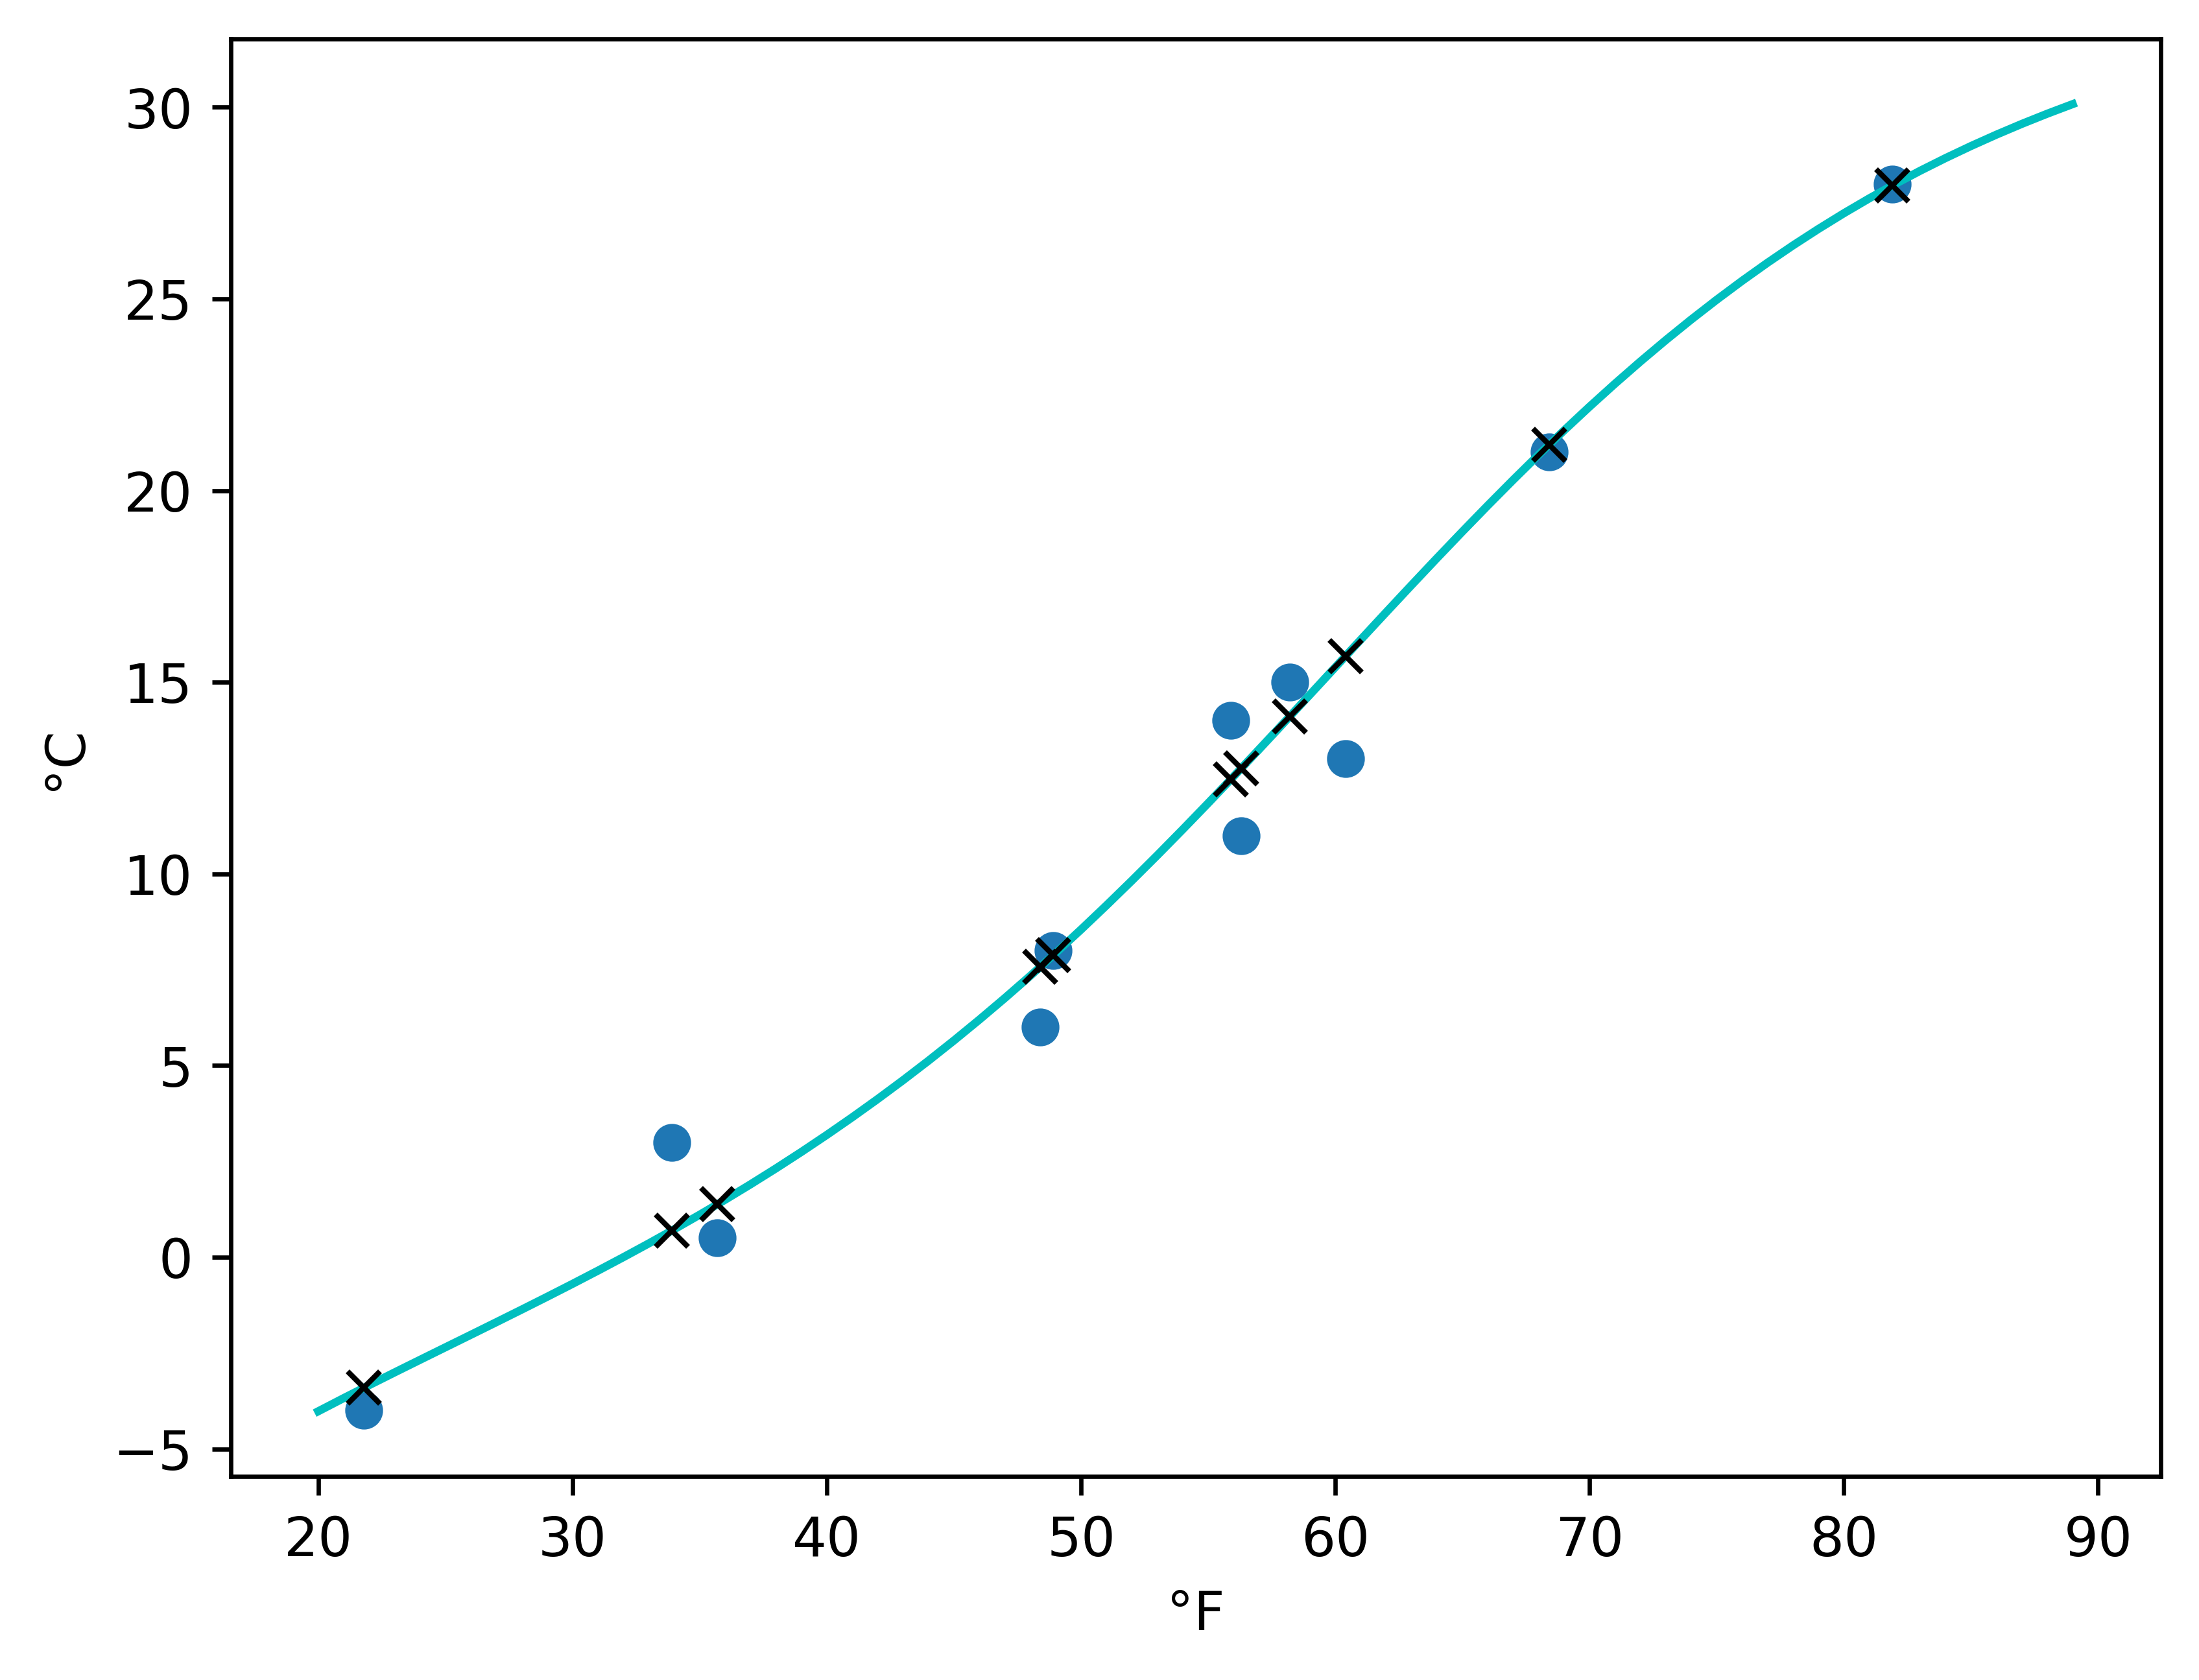

In [18]:
# plot something...
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel('°F')
plt.ylabel('°C')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')